# Model improvment

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/processed/features_dataset.csv', parse_dates=['date'])
df = df.sort_values('date').set_index('date')

## Feature Improvent

Add longer Brent lags: fuel prices sometimes react to oil prices after 2–4 weeks, sometimes even longer.

In [2]:
for lag in [5, 6, 7, 8]:
    df[f'brent_eur_lag{lag}'] = df['brent_eur'].shift(lag)

Add rolling volatility: prices react not only to levels but to instability of oil markets.

In [3]:
df['brent_vol4'] = df['brent_eur'].rolling(4).std()
df['brent_vol8'] = df['brent_eur'].rolling(8).std()

Add week-to-week differences: this is extremely useful for regression models.

In [4]:
df['benzina_diff'] = df['benzina'].diff()
df['gasolio_diff'] = df['gasolio'].diff()
df['brent_diff']   = df['brent_eur'].diff()

Add interaction features: helps capture nonlinear effects.

In [5]:
df['brent_trend'] = df['brent_eur_lag1'] * df['brent_pct_change']
df['fuel_trend']  = df['benzina_lag1']   * df['brent_pct_change']

Add improved seasonal features: add Fourier seasonality, which captures smoother yearly cycles

In [6]:
df['sin_week'] = np.sin(2 * np.pi * df.index.isocalendar().week / 52)
df['cos_week'] = np.cos(2 * np.pi * df.index.isocalendar().week / 52)

Add spread differences

In [7]:
df['spread_bg'] = df['benzina'] - df['gasolio']
df['spread_bg_diff'] = df['spread_bg'].diff()
df['spread_bg_lag2'] = df['spread_bg'].shift(2)

Clean up (drop NaNs and save)

In [8]:
df = df.dropna().reset_index()
df.to_csv('../data/processed/features_dataset_v2.csv', index=False)

## Retrain the models with the improved features

In [9]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

df = pd.read_csv('../data/processed/features_dataset_v2.csv', parse_dates=['date'])
df = df.sort_values('date').reset_index(drop=True)

# Target shift
df['benzina_next'] = df['benzina'].shift(-1)
df['gasolio_next'] = df['gasolio'].shift(-1)
df = df.dropna().reset_index(drop=True)


Prepare X and y:

In [10]:
feature_cols = [c for c in df.columns 
                if c not in ['date','benzina','gasolio','benzina_next','gasolio_next']]

X = df[feature_cols]
y_b = df['benzina_next']
y_g = df['gasolio_next']

Train/test split (last 52 weeks as test):

In [11]:
test_size = 52

X_train = X[:-test_size]
X_test  = X[-test_size:]

y_train_b = y_b[:-test_size]
y_test_b  = y_b[-test_size:]

y_train_g = y_g[:-test_size]
y_test_g  = y_g[-test_size:]


Train models:

In [12]:
ridge_b = Ridge(alpha=1.0).fit(X_train, y_train_b)
gbr_b   = GradientBoostingRegressor().fit(X_train, y_train_b)

ridge_g = Ridge(alpha=1.0).fit(X_train, y_train_g)
gbr_g   = GradientBoostingRegressor().fit(X_train, y_train_g)


Evaluate:

In [13]:
def eval(model, X, y):
    pred = model.predict(X)
    mae  = mean_absolute_error(y, pred)
    rmse = np.sqrt(mean_squared_error(y, pred))
    return mae, rmse

print("Ridge Benzina", eval(ridge_b, X_test, y_test_b))
print("GBR Benzina",   eval(gbr_b, X_test, y_test_b))

print("Ridge Gasolio", eval(ridge_g, X_test, y_test_g))
print("GBR Gasolio",   eval(gbr_g, X_test, y_test_g))


Ridge Benzina (0.007685770402023511, np.float64(0.009743078439796066))
GBR Benzina (0.007641039955084716, np.float64(0.00990497625075313))
Ridge Gasolio (0.010878750700061753, np.float64(0.01472615899834664))
GBR Gasolio (0.011609034534382189, np.float64(0.014770700016108336))


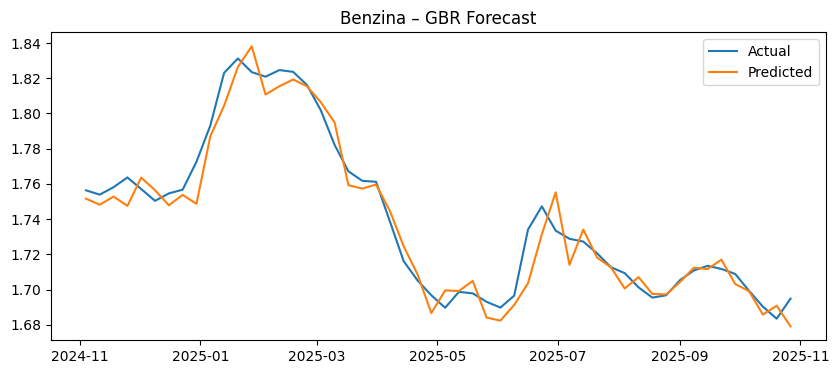

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df['date'].iloc[-52:], y_test_b, label='Actual')
plt.plot(df['date'].iloc[-52:], gbr_b.predict(X_test), label='Predicted')
plt.title('Benzina – GBR Forecast')
plt.legend()
plt.show()